## Setup

In [2]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from src.regex_pattern_generator import generate_regex_patterns


# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200 # words to display for context

In [4]:
PHRASES = ['Violence / Violent',
'Transgender',
'TikTok',
'Terrorist / Terrorism',
'Tariff',
'Sanction',
'Russia / Ukraine',
'The Left / Radical Left',
'RICO',
'Republican',
'Oil',
'NATO',
'Murder',
'Investment',
'Investigate / Investigation',
'Gaza / Israel',
'Fund / Funding',
'DOJ / Justice',
'Democrat',
'Crime',
'College / University',
'China',
'Charlie',
'Biden',
'Antifa']

SEARCH_PHRASES = generate_regex_patterns(PHRASES)

from pprint import pprint
pprint(SEARCH_PHRASES)

{'Antifa': "\\b(?:\\w+-)*antifa|antifas|antifa's|antifas'(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Biden': "\\b(?:\\w+-)*biden|bidens|biden's|bidens'(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Charlie': "\\b(?:\\w+-)*charlie|charlies|charlie's|charlies'(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'China': "\\b(?:\\w+-)*china|chinas|china's|chinas'(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'College / University': "\\b(?:\\w+-)*(?:college|colleges|college's|colleges'|university|universities|university's|universitys'|universities')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Crime': "\\b(?:\\w+-)*crime|crimes|crime's|crimes'(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'DOJ / Justice': "\\b(?:\\w+-)*(?:doj|dojs|doj's|dojs'|justice|justices|justice's|justices')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Democrat': "\\b(?:\\w+-)*democrat|democrats|democrat's|democrats'(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Fund / Funding': "\\b(?:\\w+-)*(?:fund|funds|fund's|funds'|funding|fundings|funding's|fundings')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Gaza / Israel': "\\b(?:\\w+-)*(?:gaza|gazas

In [5]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)


In [7]:
# Find all files containing "signs" in the processed transcripts directory
import glob

def find_signing_files(directory):
    """Find all transcript files containing 'signs' in the filename"""
    signing_files = []
    
    # Search recursively for all .txt files containing "signs"
    pattern = os.path.join(directory, '**', '*signs*.txt')
    files = glob.glob(pattern, recursive=True)
    
    for filepath in files:
        # Get relative path from the directory
        rel_path = os.path.relpath(filepath, directory)
        signing_files.append({
            'filepath': filepath,
            'filename': os.path.basename(filepath),
            'category': os.path.basename(os.path.dirname(filepath)),
            'relative_path': rel_path
        })
    
    return signing_files

# Find all signing-related files
signing_files = find_signing_files('../data/processed-transcripts')

print(f"Found {len(signing_files)} files containing 'signs' in the filename:")
print("=" * 60)

for file_info in signing_files:
    print(f"Category: {file_info['category']}")
    print(f"Filename: {file_info['filename']}")
    print(f"Path: {file_info['relative_path']}")
    print("-" * 40)

if not signing_files:
    print("No files containing 'signs' found in the processed transcripts directory.")


Found 37 files containing 'signs' in the filename:
Category: remarks
Filename: 2025-02-10_donald_trump_signs_executive_orders_in_the_oval_office.txt
Path: remarks/2025-02-10_donald_trump_signs_executive_orders_in_the_oval_office.txt
----------------------------------------
Category: remarks
Filename: 2025-08-07_donald_trump_signs_an_proclamation_for_national_purple_heart_day.txt
Path: remarks/2025-08-07_donald_trump_signs_an_proclamation_for_national_purple_heart_day.txt
----------------------------------------
Category: remarks
Filename: 2025-02-03_donald_trump_signs_executive_orders_and_appointments_in_the_oval_office.txt
Path: remarks/2025-02-03_donald_trump_signs_executive_orders_and_appointments_in_the_oval_office.txt
----------------------------------------
Category: remarks
Filename: 2025-02-13_donald_trump_signs_executive_orders_in_the_oval_office.txt
Path: remarks/2025-02-13_donald_trump_signs_executive_orders_in_the_oval_office.txt
----------------------------------------
Cat

In [15]:
# Set the category of interest
CATEGORY_OF_INTEREST = "signings"

# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Filter out press briefings and state of the union
df = df[df['category'] != 'press briefing']
df = df[df['category'] != 'sotu']
df = df[df['category'] != 'un-addresses']

# Split data by date and category
speech_mask = df['category'] == 'speech'
date_mask = df['date'] >= INAUGURATION_DATE

# Create category of interest dataframes 
df_category = df[df['file'].isin([f['filename'] for f in signing_files])]
df_category_pre = df_category[~date_mask]
df_category_post = df_category[date_mask]

df_non_category = df[~df['file'].isin([f['filename'] for f in signing_files])]

# Create SOTU dataframes
sotu_mask = df['category'] == 'sotu'
df_sotu = df[sotu_mask]

df_pre = df[~date_mask]
df_post = df[date_mask]

# Print dataset statistics
print("Dataset Statistics:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Pre-inauguration: {len(df_category_pre)}")
print(f"Post-inauguration: {len(df_category_post)}")
print("\nState of the Union:")
print(f"Total: {len(df_sotu)}")

print("\nWord Count Statistics:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Category average length: {df_category['text_length'].mean():.0f} words") 


Categories found in directory:
- donald trump vlog
- interview
- interview - pending
- press briefing
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech
- un-addresses
- uncategorized

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:

Signingss:
Pre-inauguration: 0
Post-inauguration: 37

State of the Union:
Total: 0

Word Count Statistics:

Signingss:
Category average length: 4575 words


/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_91643/1821724126.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_category_pre = df_category[~date_mask]
/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_91643/1821724126.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_category_post = df_category[date_mask]


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)


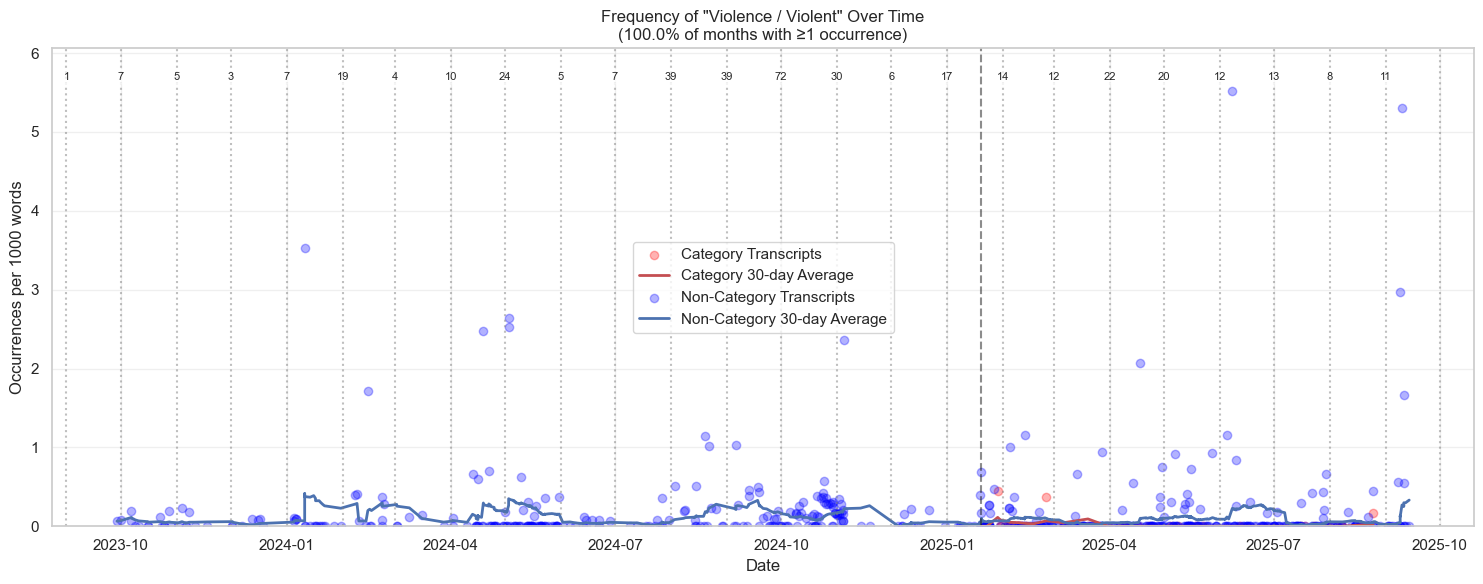


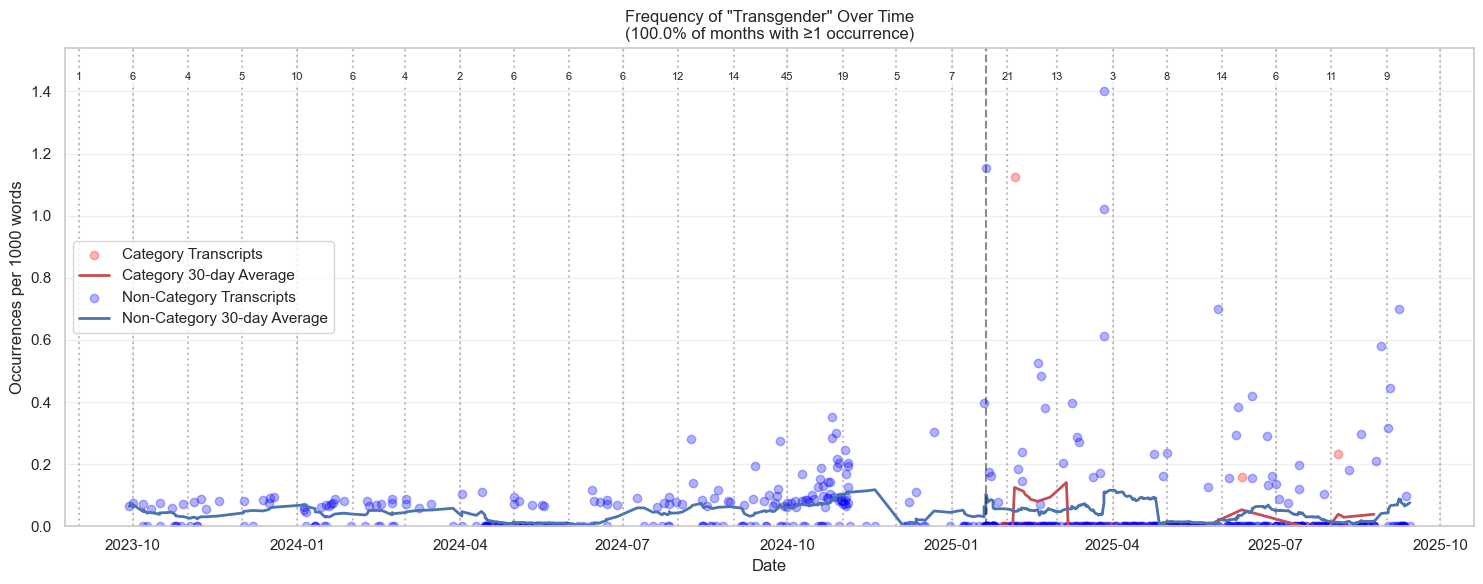


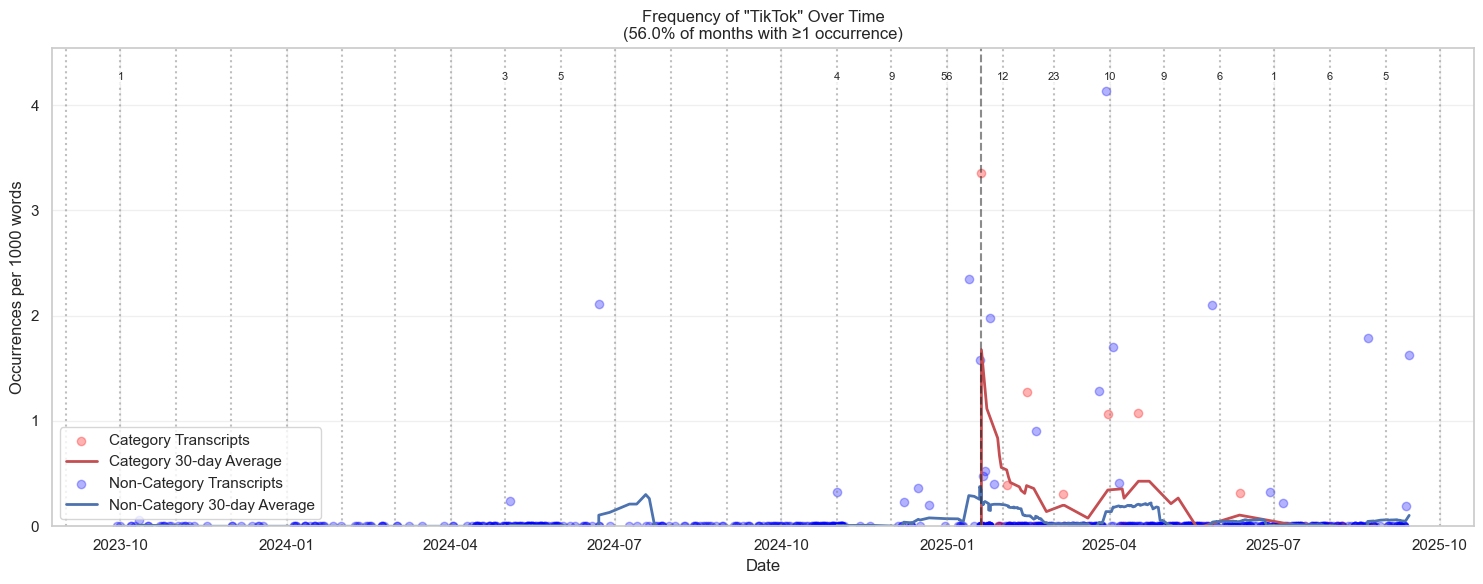


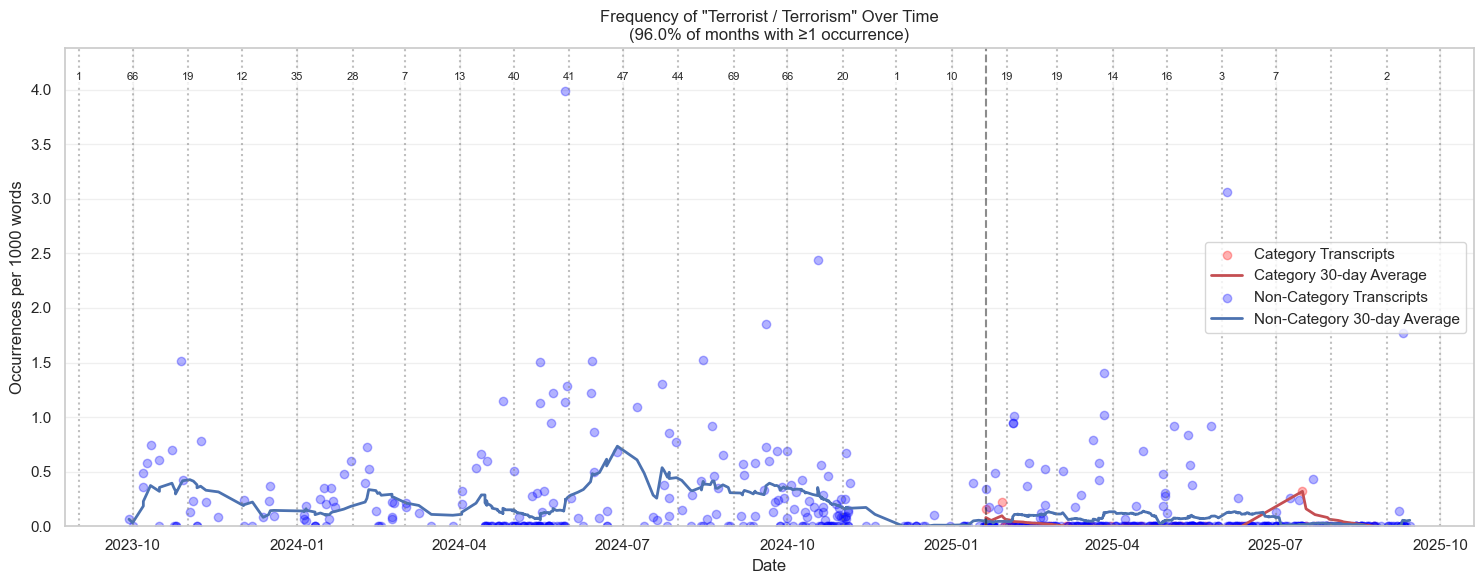


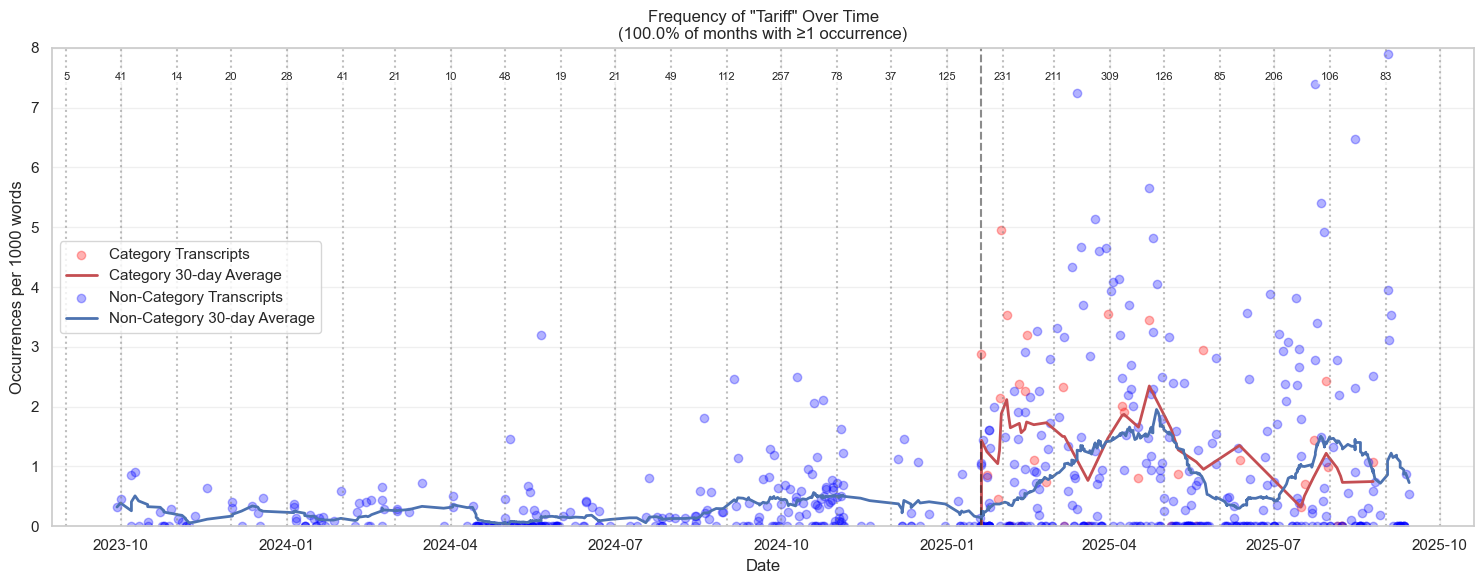


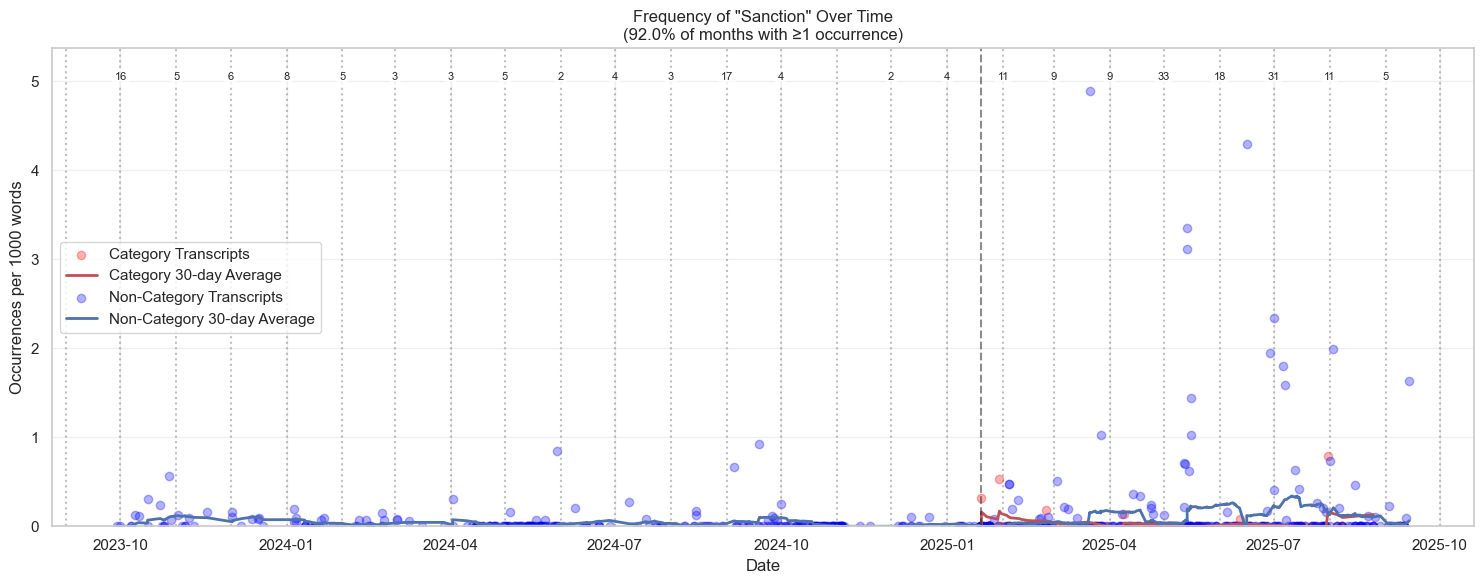


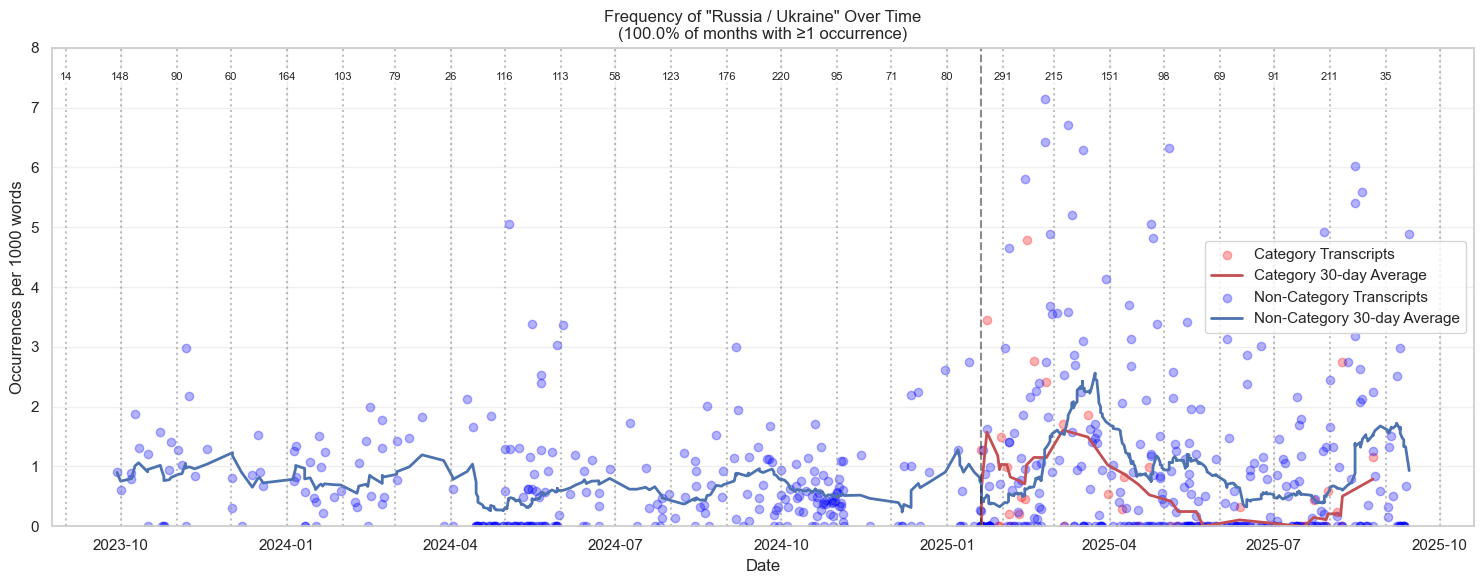


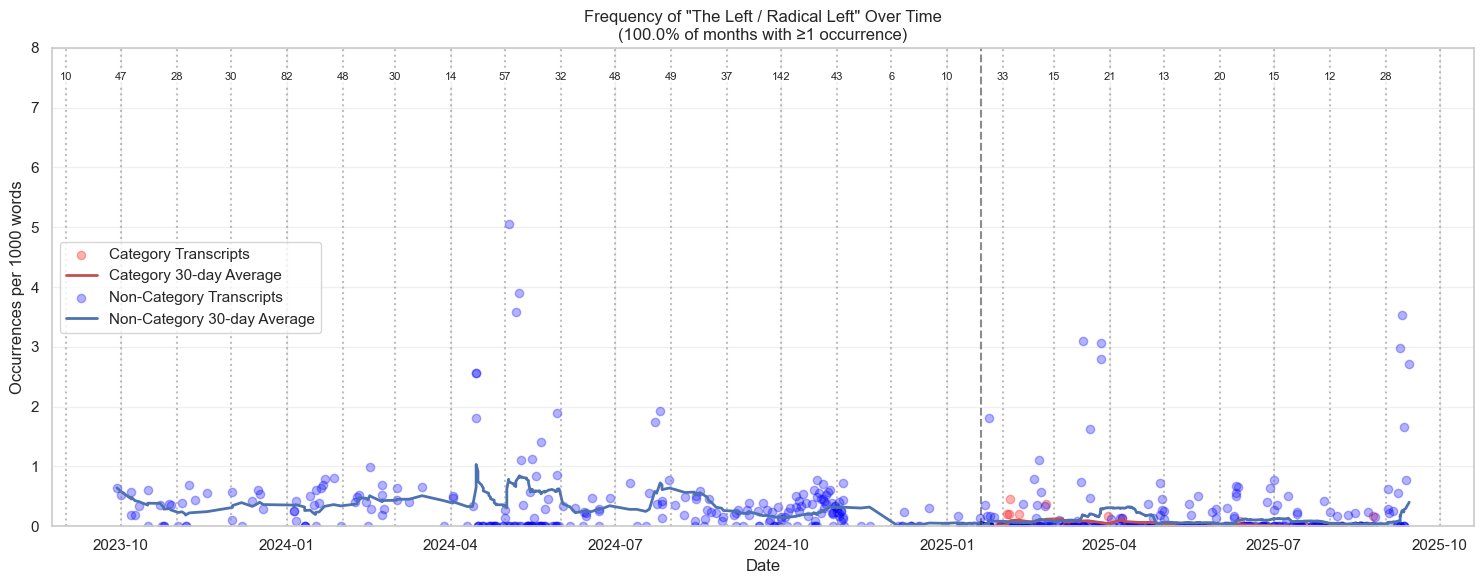


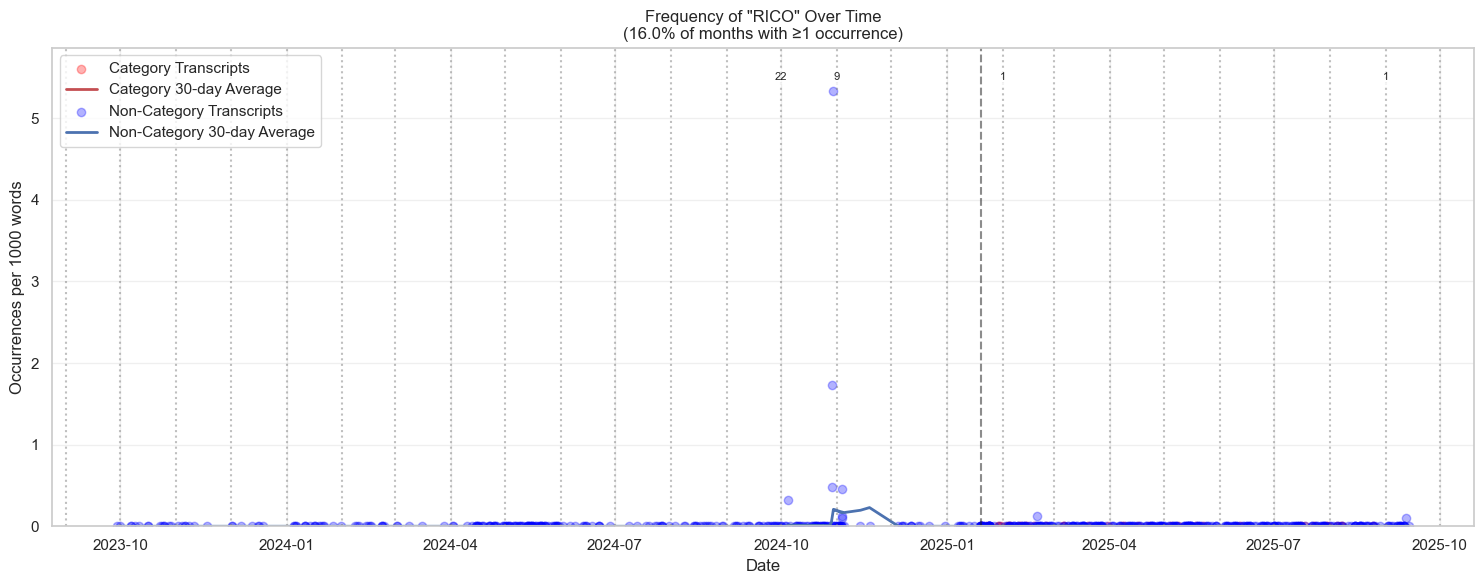


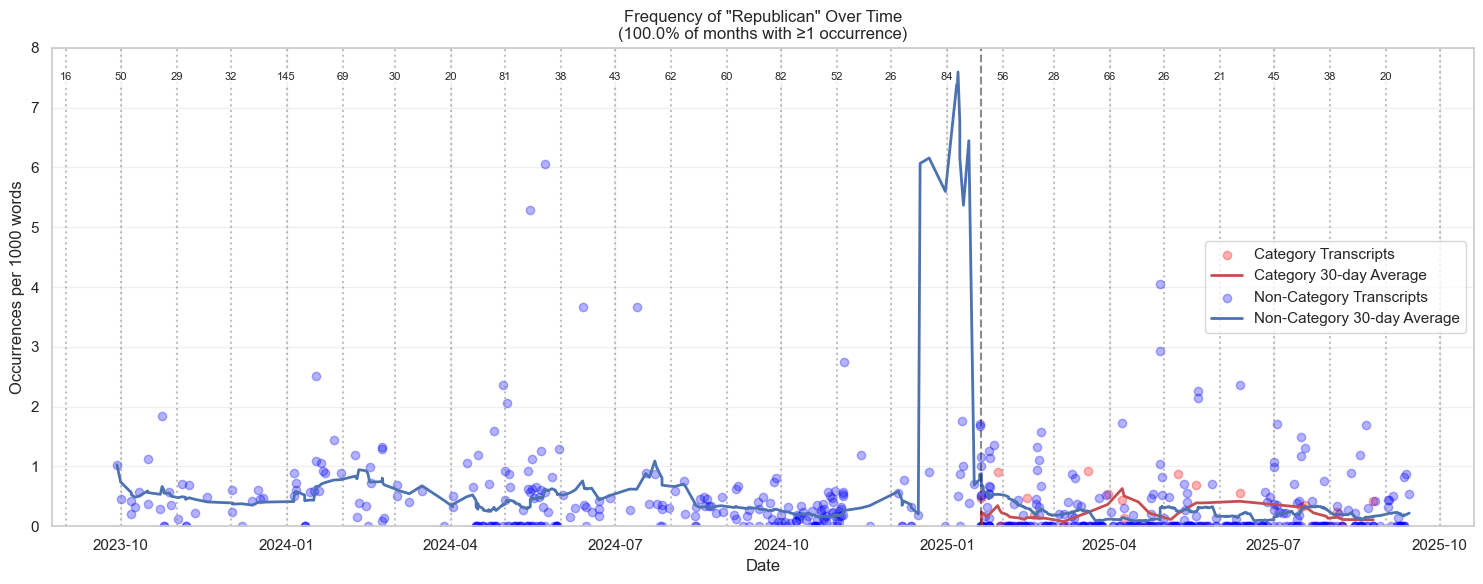


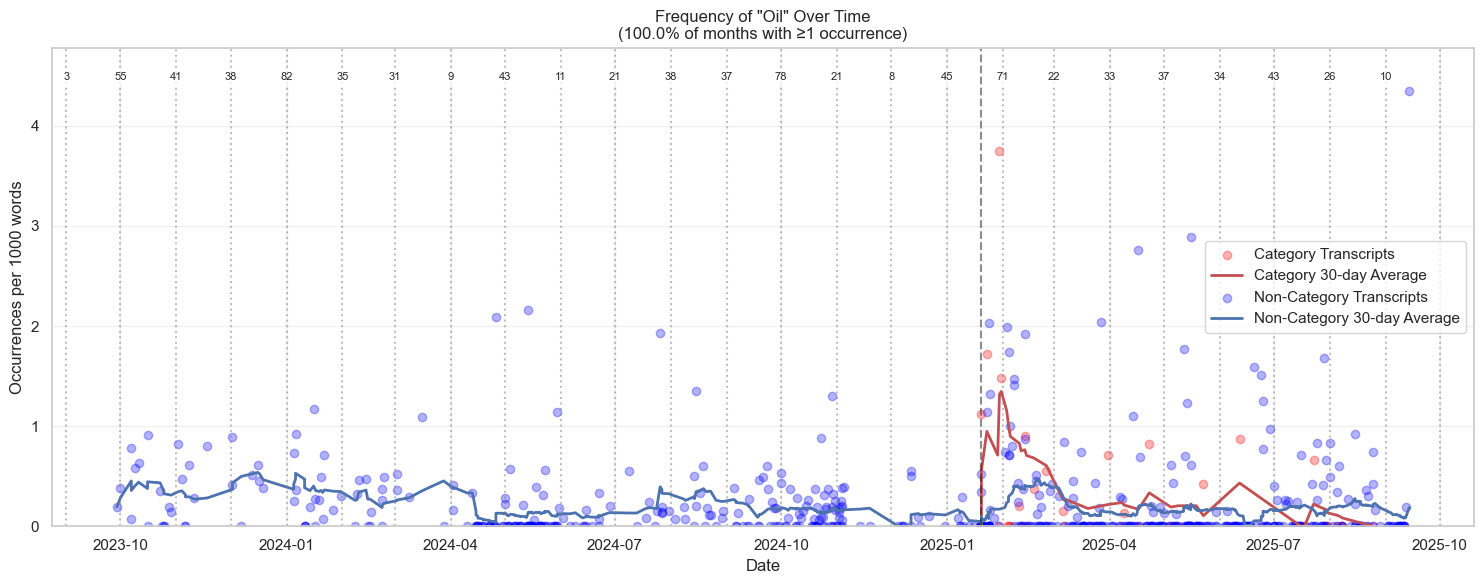


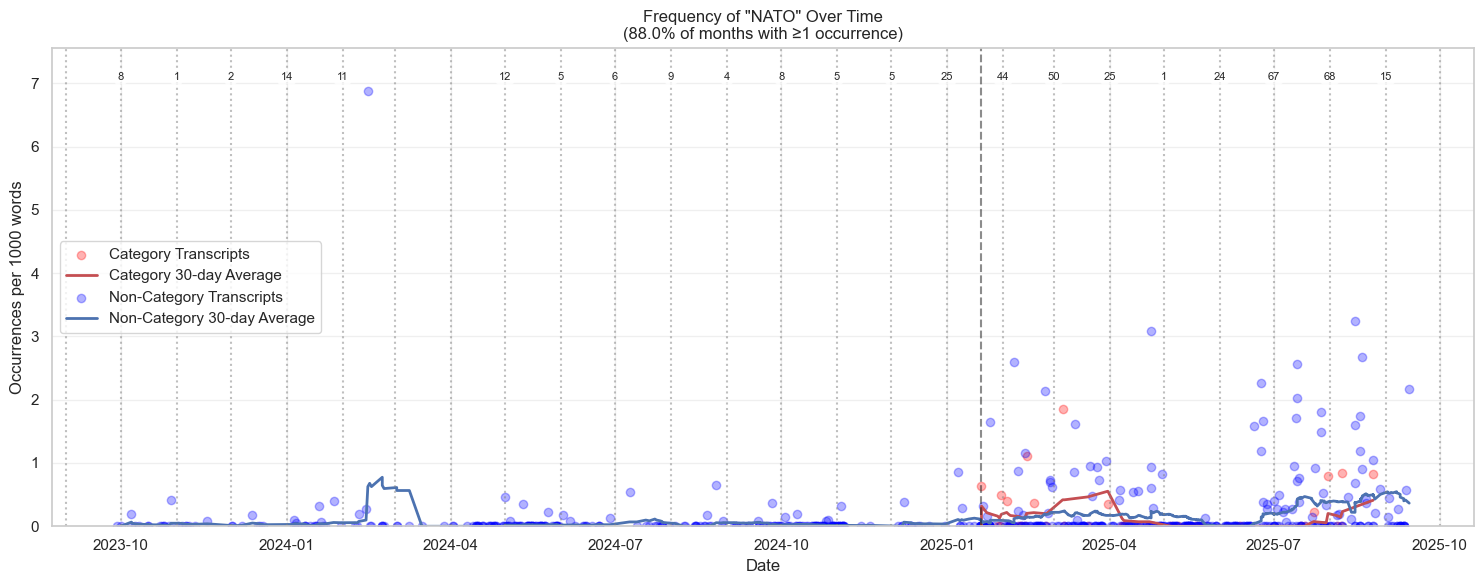


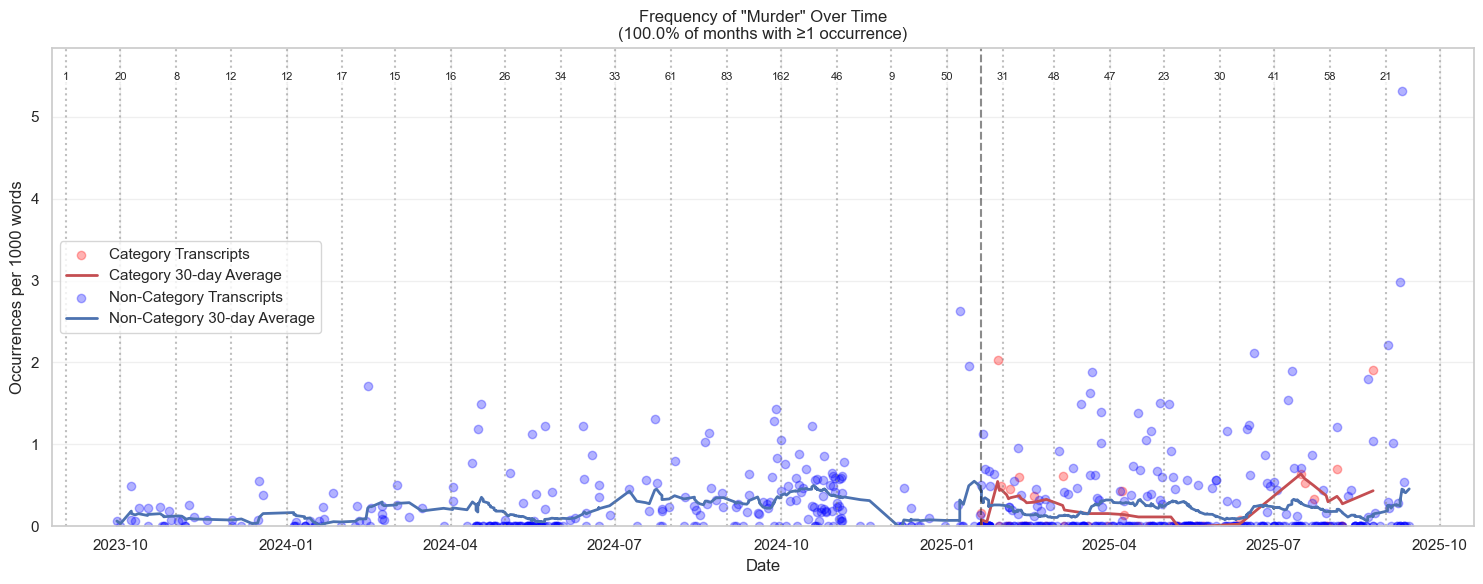


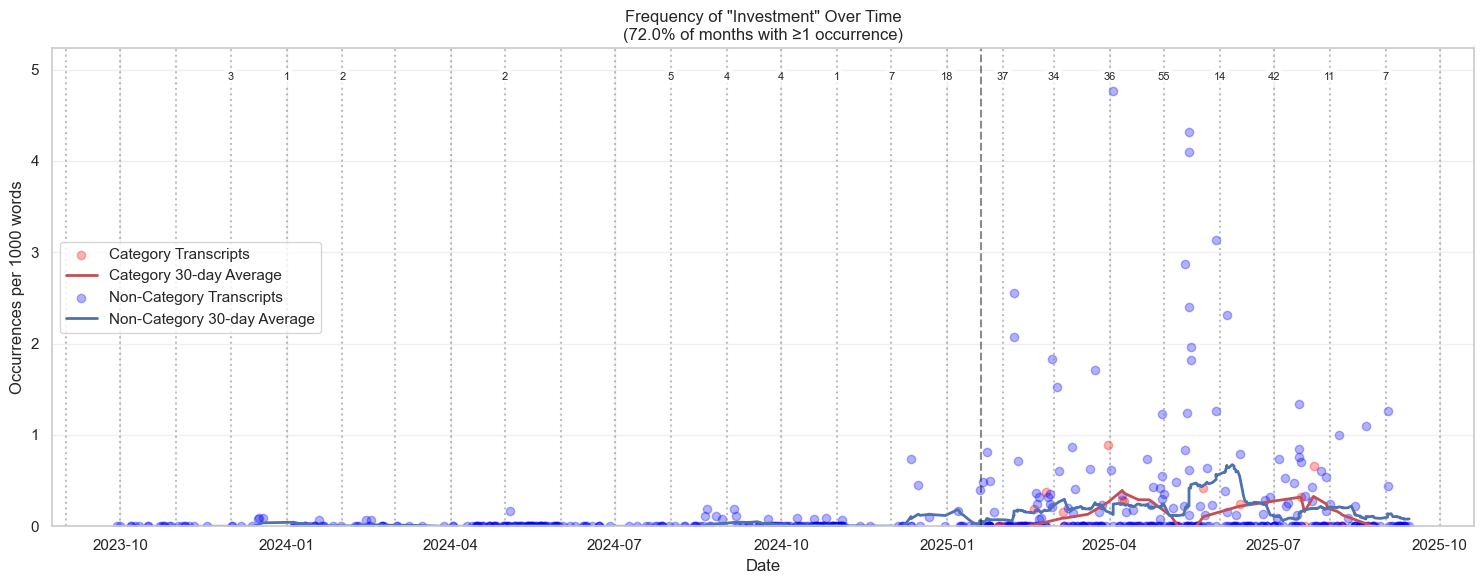


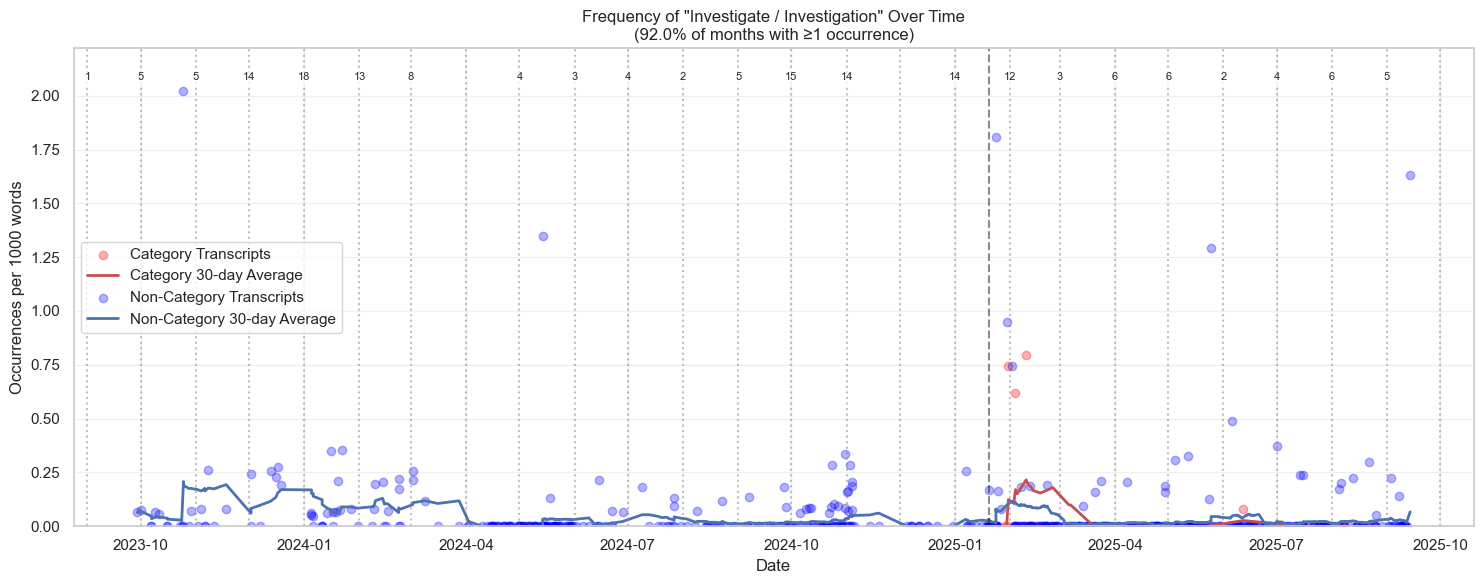


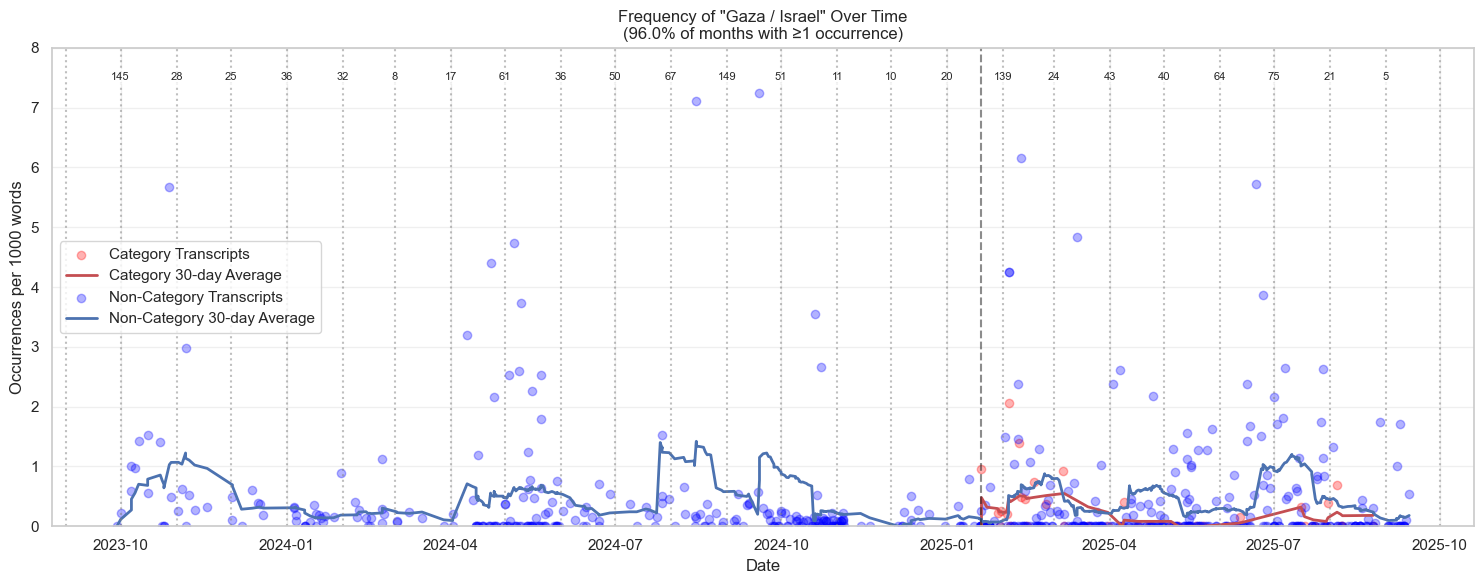


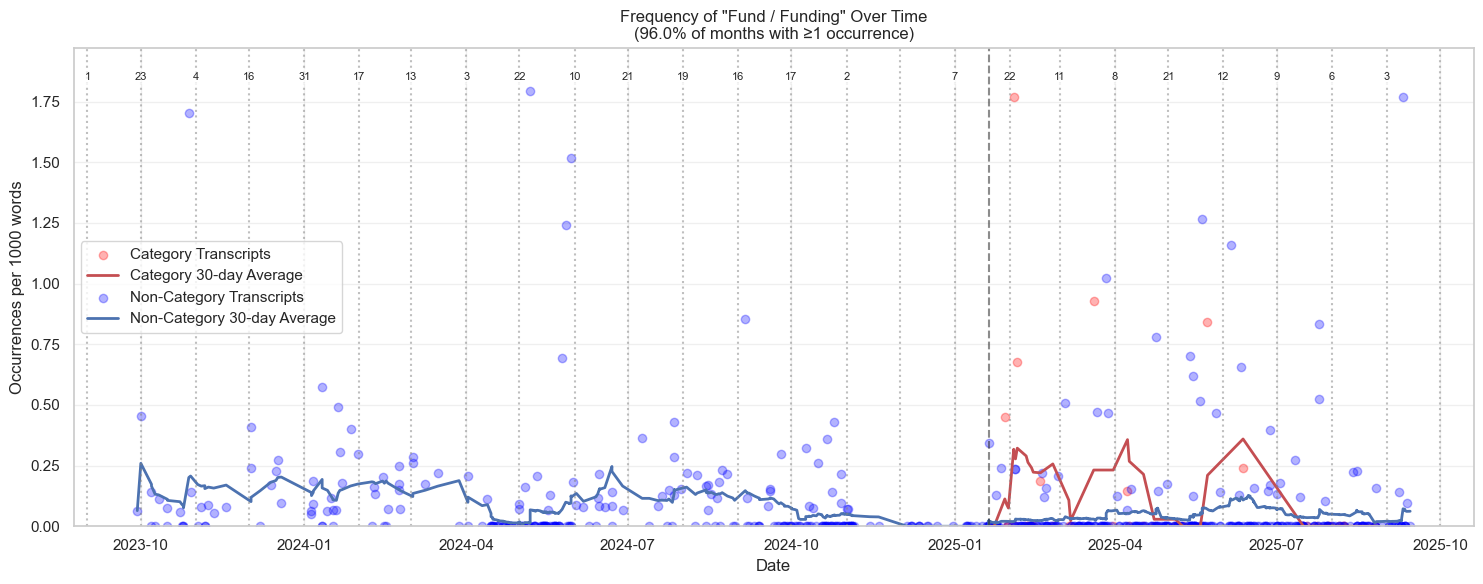


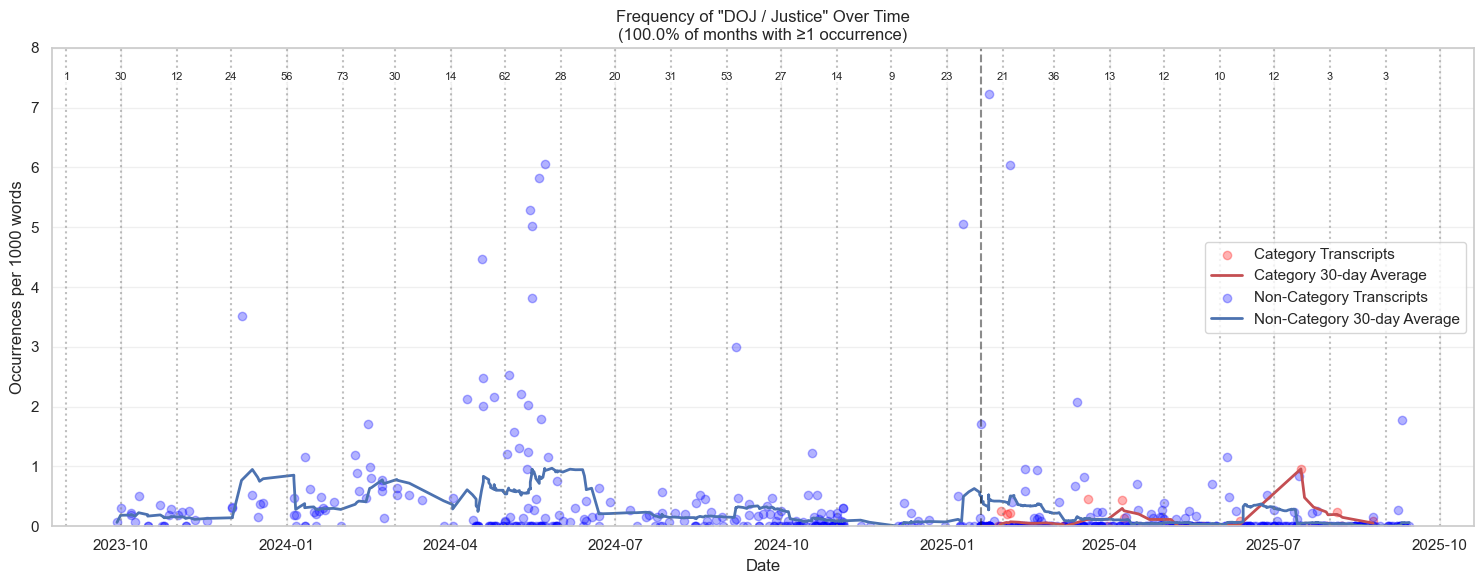


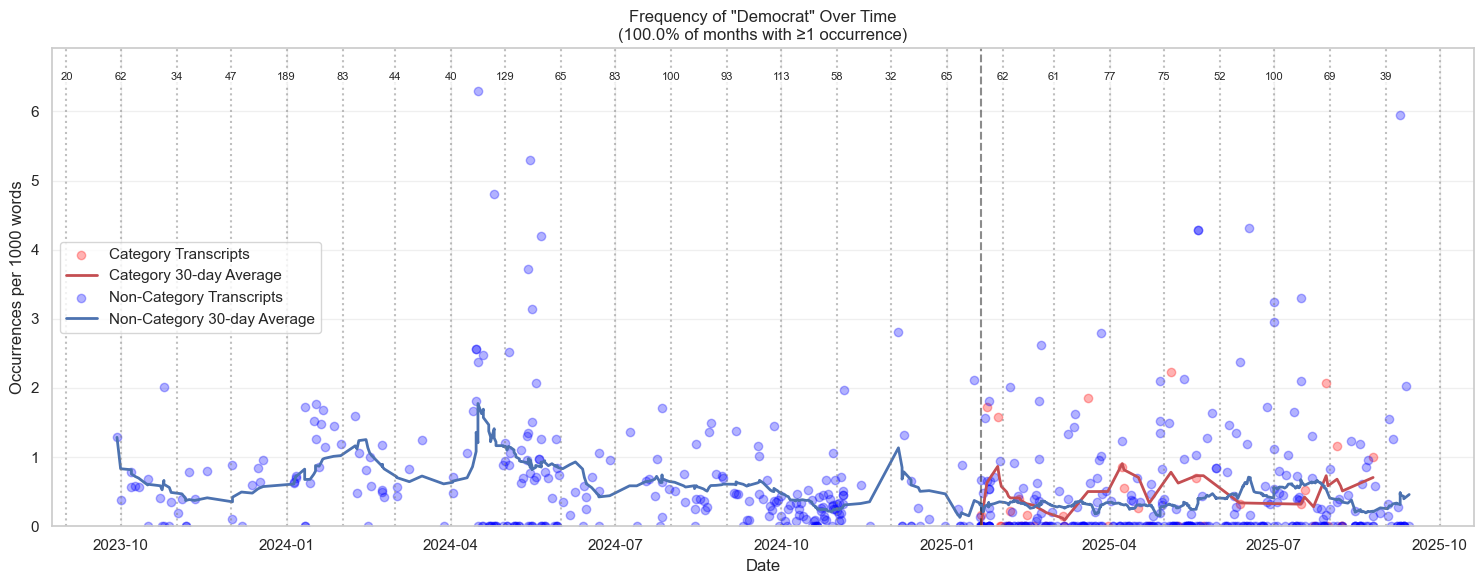


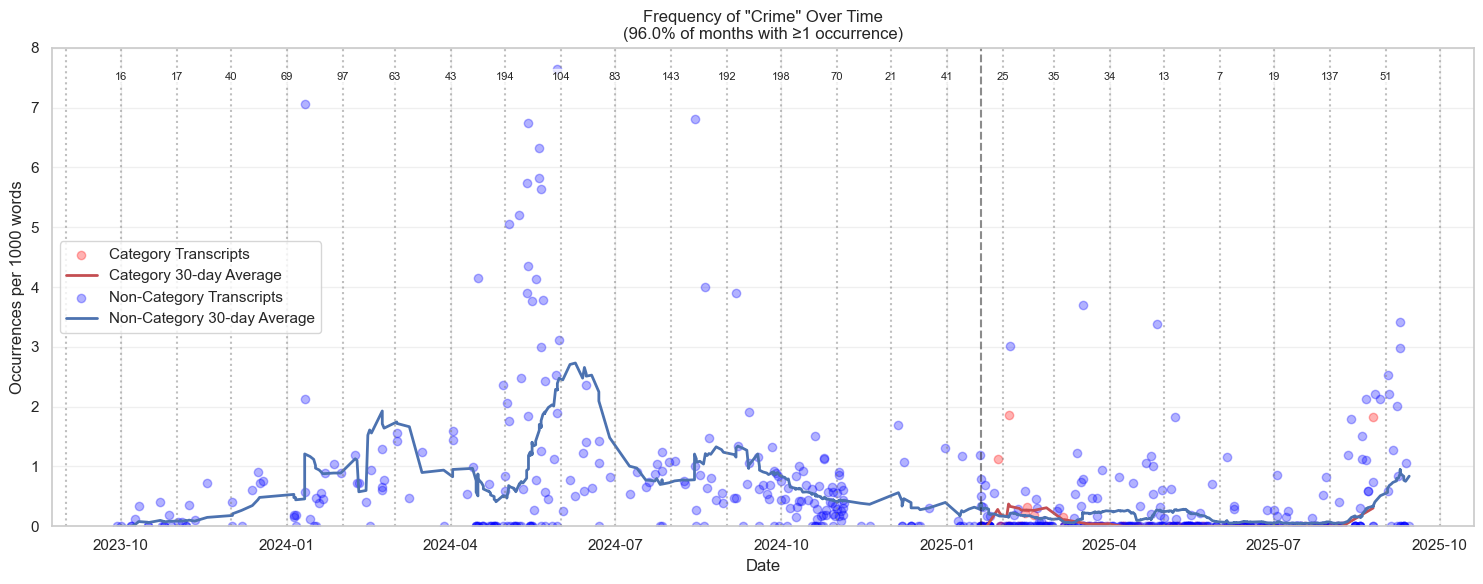


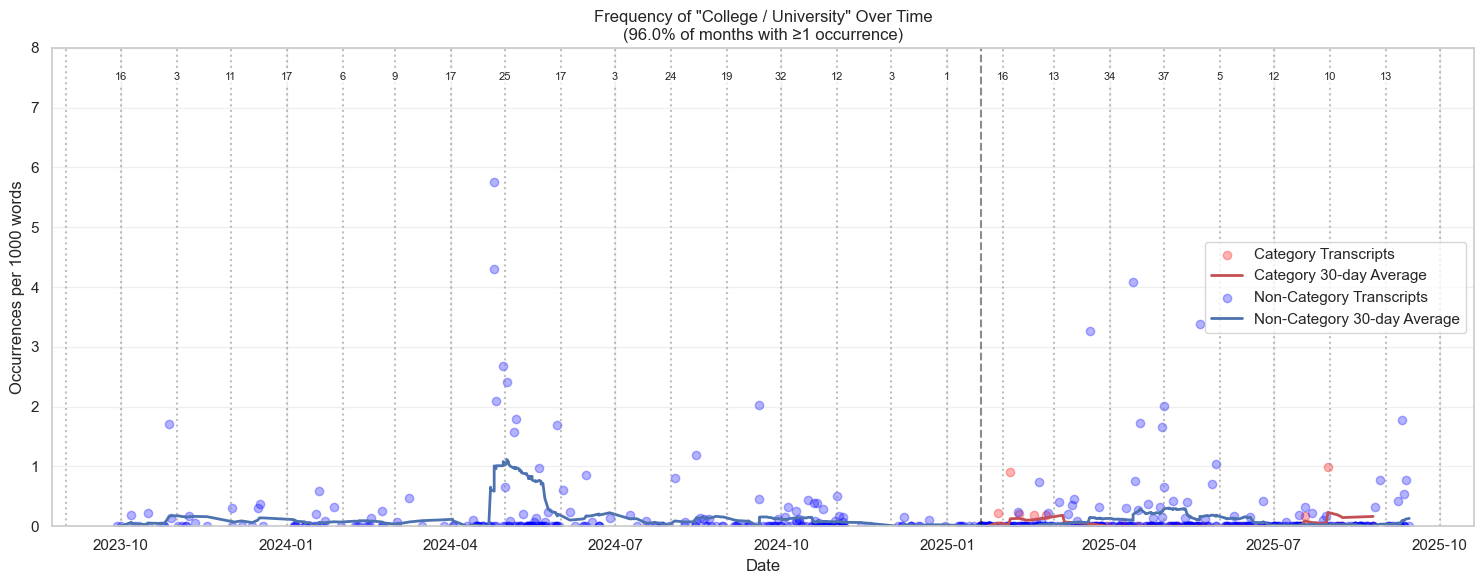


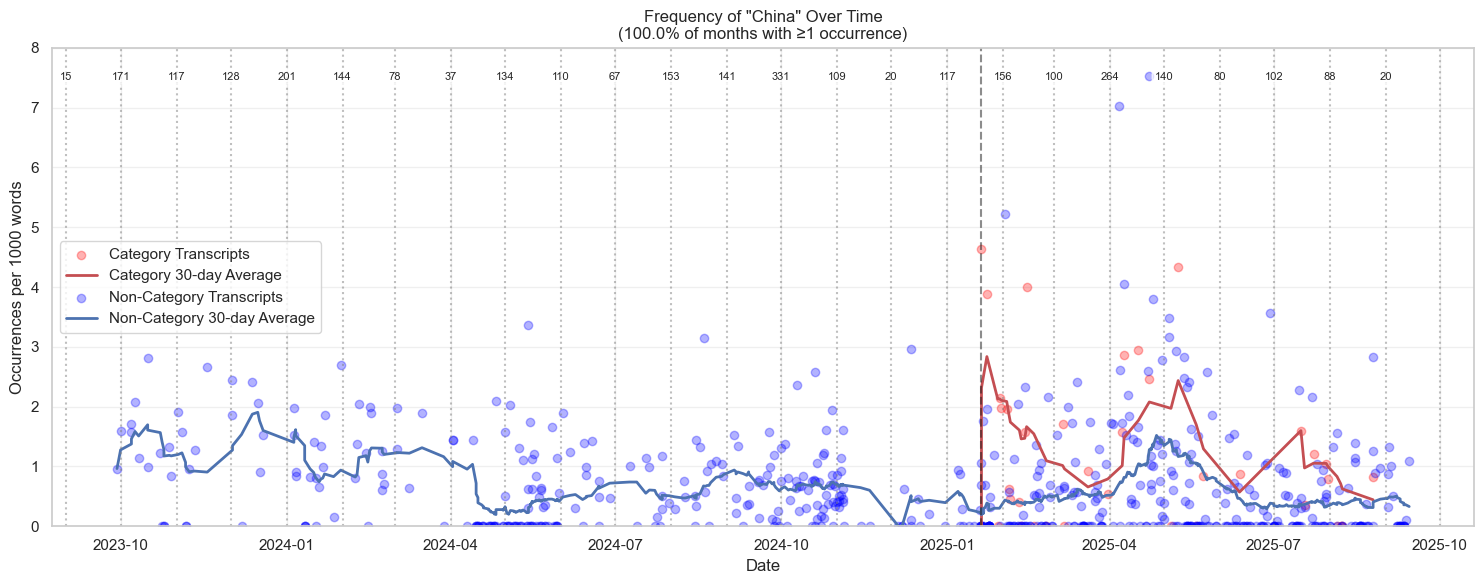


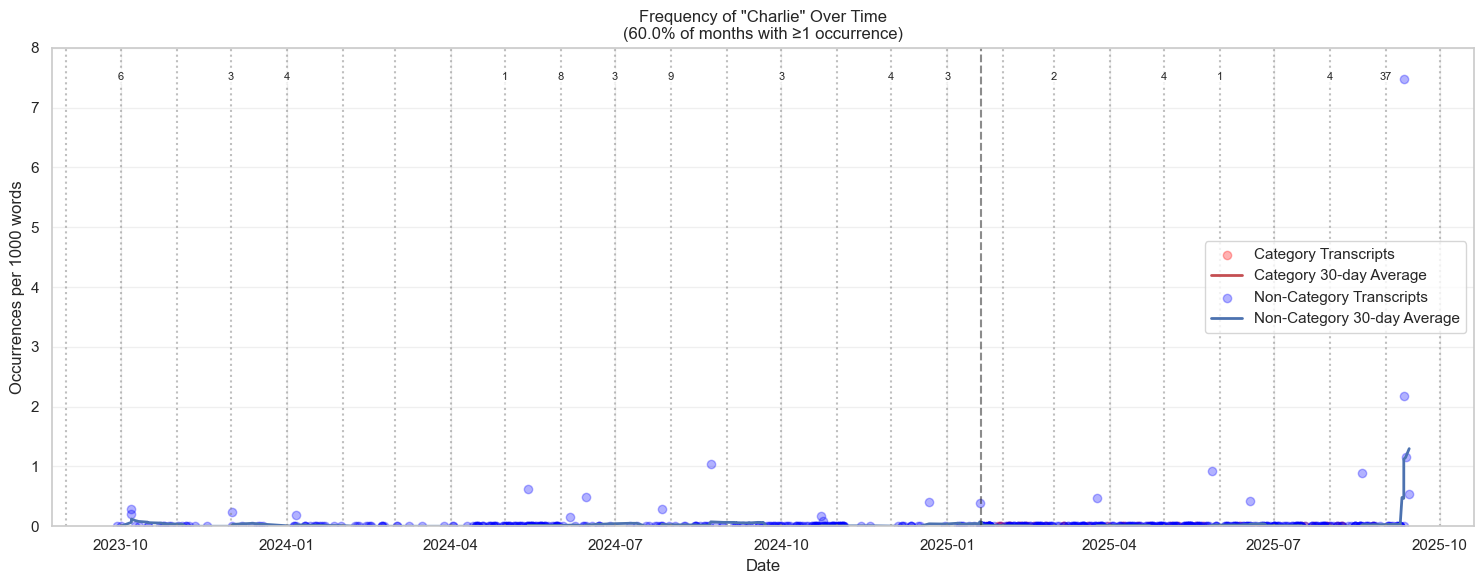


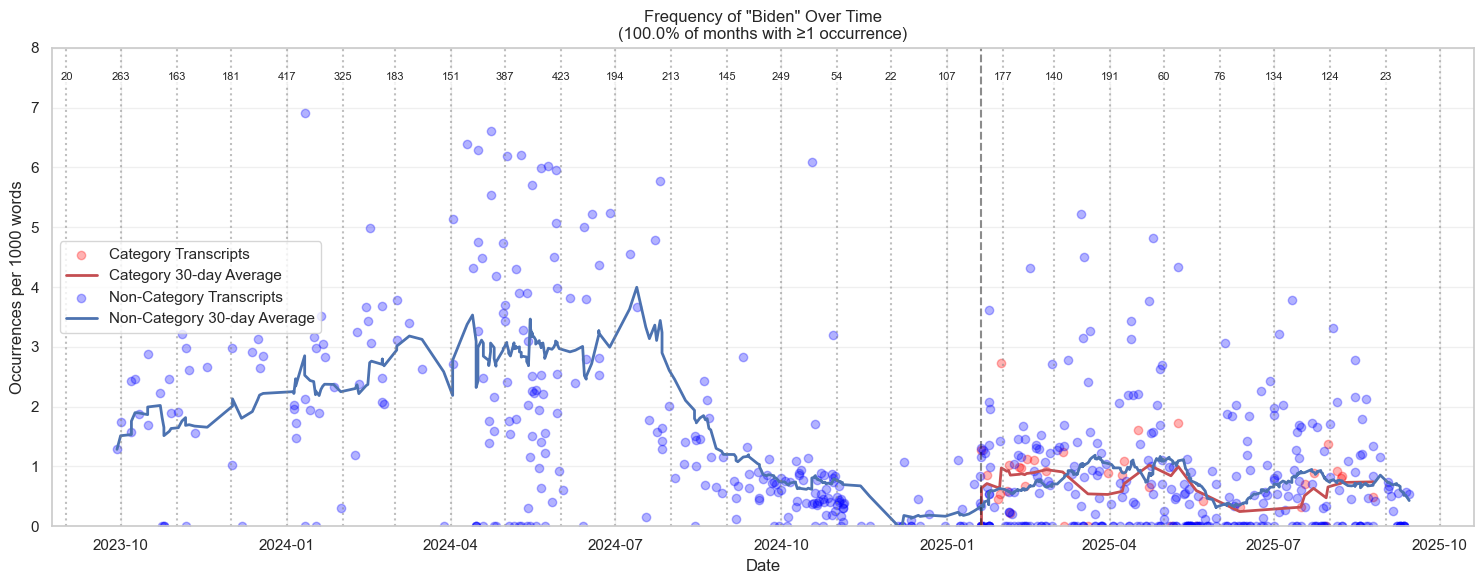


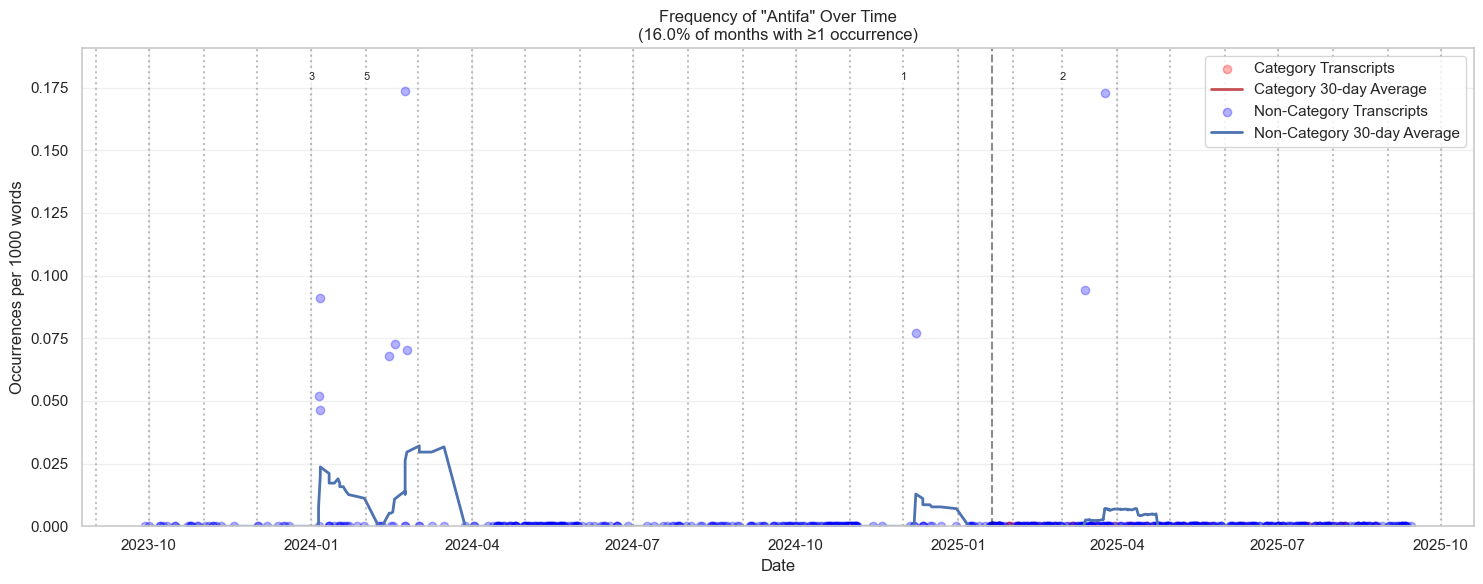

In [29]:
def plot_phrase_frequency_over_time(df_category, df_non_category, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for category and non-category"""
    from IPython.display import HTML, display
    
    plt.figure(figsize=(15, 6))
    
    # Process category data
    df_category = df_category.copy()
    df_category[f'{phrase}_freq'] = (df_category[phrase] / df_category['text_length']) * 1000
    category_series = df_category.set_index('date')[f'{phrase}_freq']
    category_rolling = category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-category data
    df_non_category = df_non_category.copy()
    df_non_category[f'{phrase}_freq'] = (df_non_category[phrase] / df_non_category['text_length']) * 1000
    non_category_series = df_non_category.set_index('date')[f'{phrase}_freq']
    non_category_rolling = non_category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot category data
    plt.scatter(category_series.index, category_series.values, alpha=0.3, color='red', label='Category Transcripts')
    plt.plot(category_rolling.index, category_rolling.values, 'r-', linewidth=2, label=f'Category {window}-day Average')
    
    # Plot non-category data
    plt.scatter(non_category_series.index, non_category_series.values, alpha=0.3, color='blue', label='Non-Category Transcripts')
    plt.plot(non_category_rolling.index, non_category_rolling.values, 'b-', linewidth=2, label=f'Non-Category {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Add monthly vertical lines and counts
    combined_df = pd.concat([df_category, df_non_category])
    if not combined_df.empty:
        date_range = pd.date_range(
            start=combined_df['date'].min().replace(day=1),
            end=combined_df['date'].max() + pd.DateOffset(months=1),
            freq='MS'  # Month start
        )
        
        # Calculate monthly statistics
        combined_df['year_month'] = combined_df['date'].dt.to_period('M')
        monthly_stats = combined_df.groupby('year_month').agg({
            phrase: 'sum',
            'date': 'count'
        }).rename(columns={'date': 'transcript_count'})
        
        # Calculate % of months with 1+ occurrence
        months_with_occurrence = (monthly_stats[phrase] >= 1).sum()
        total_months = len(monthly_stats)
        pct_months_with_occurrence = (months_with_occurrence / total_months * 100) if total_months > 0 else 0
        
        # Add monthly vertical lines and counts
        for date in date_range:
            plt.axvline(x=date, color='gray', linestyle=':', alpha=0.5)
            
            # Get monthly count for this date
            period = date.to_period('M')
            if period in monthly_stats.index:
                monthly_count = monthly_stats.loc[period, phrase]
                if monthly_count > 0:
                    # Position text at top of plot
                    ymax = min(8, max(
                        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
                        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
                    ) * 1.1)
                    plt.text(date, ymax * 0.95, str(int(monthly_count)), 
                            ha='center', va='top', fontsize=8, 
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Add percentage to title
        plt.title(f'Frequency of "{phrase}" Over Time\n({pct_months_with_occurrence:.1f}% of months with ≥1 occurrence)')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    
    # Save plot to base64 string for embedding in HTML
    import io
    import base64
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    plot_data = base64.b64encode(buf.read()).decode()
    plt.close()  # Close the figure to free memory
    
    # Create collapsible HTML
    html = f"""
    <details>
        <summary style="cursor: pointer; font-weight: bold; font-size: 14px; padding: 5px;">
            📊 {phrase} - Frequency Over Time
        </summary>
        <div style="margin-top: 10px;">
            <img src="data:image/png;base64,{plot_data}" style="max-width: 100%; height: auto;">
        </div>
    </details>
    """
    
    display(HTML(html))

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    category_freq = (df_category[phrase].sum() / df_category['text_length'].sum()) * 1000 if not df_category.empty and df_category['text_length'].sum() > 0 else 0
    non_category_freq = (df_non_category[phrase].sum() / df_non_category['text_length'].sum()) * 1000 if not df_non_category.empty and df_non_category['text_length'].sum() > 0 else 0
    phrase_freqs[phrase] = (category_freq + non_category_freq) / 2

for phrase in phrase_freqs:
    plot_phrase_frequency_over_time(df_category, df_non_category, phrase)

Expected length from category data: 4575 words


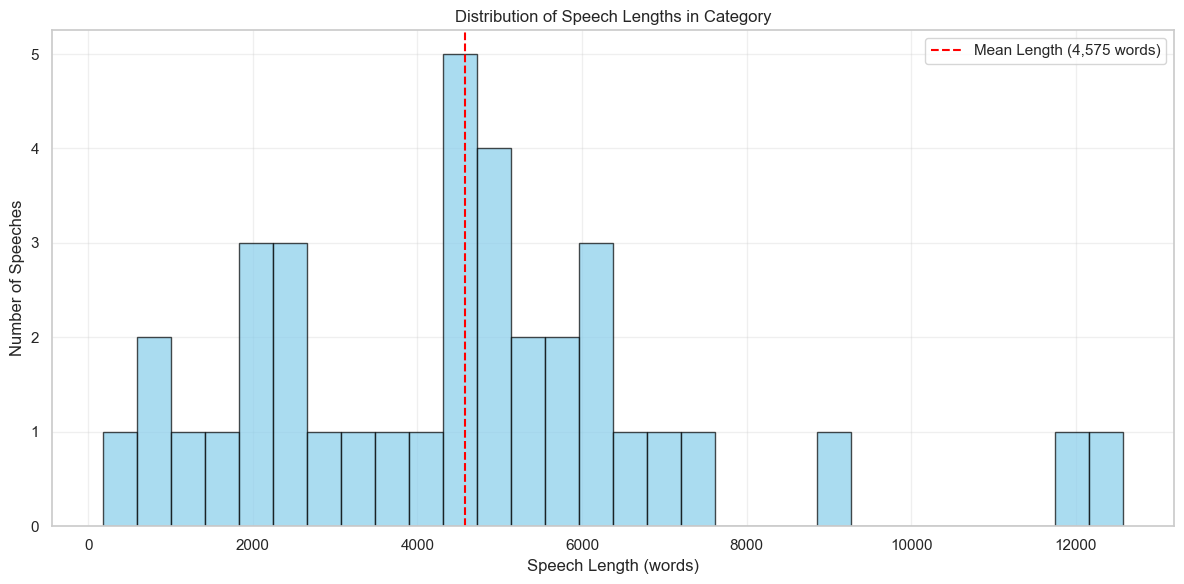

In [17]:
# Calculate expected length from the chosen category
expected_length = df_category['text_length'].mean()
print(f"Expected length from category data: {expected_length:.0f} words")

# Show histogram of category lengths
plt.figure(figsize=(12, 6))
plt.hist(df_category['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=expected_length, color='red', linestyle='--', label=f'Mean Length ({int(expected_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title(f'Distribution of Speech Lengths in Category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [18]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

In [11]:


length = 10000

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, length)
predictions_speeches = calculate_poisson_predictions(df_speech, length)
predictions_post_all = calculate_poisson_predictions(pd.concat([df_nonspeech_post, df_speech_post]), length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on all speeches:")
display(format_prediction_table(predictions_speeches, 'post-inauguration-speeches'))

print("\nPredictions based on all post-inauguration appearances:")
display(format_prediction_table(predictions_post_all, 'post-inauguration-all'))

NameError: name 'df_speech' is not defined

## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

In [20]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Skip phrases that don't exist in the dataframe
        if phrase not in df.columns:
            continue
            
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    formatted['P(≥1)'] = formatted['P(≥1)'].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

def compare_models(poisson_df, nb_df):
    """Compare Poisson and Negative Binomial predictions"""
    comparison = pd.DataFrame()
    comparison['Phrase'] = poisson_df['Phrase']
    comparison['Expected'] = poisson_df['Expected']
    
    # Convert percentage strings back to floats for calculations
    comparison['Poisson P(≥1)'] = poisson_df['P(≥1)'].astype(float)
    comparison['NB P(≥1)'] = nb_df['P(≥1)'].astype(float)
    comparison['Δ P(≥1)'] = (comparison['NB P(≥1)'] - comparison['Poisson P(≥1)']) * 100
    
    comparison['Dispersion (r)'] = nb_df['Dispersion (r)']
    comparison['Sample Variance'] = nb_df['Sample Variance']
    
    # Format probability columns as percentages
    comparison['Poisson P(≥1)'] = comparison['Poisson P(≥1)'].map('{:.1%}'.format)
    comparison['NB P(≥1)'] = comparison['NB P(≥1)'].map('{:.1%}'.format)
    
    return comparison.round(3).sort_values('Δ P(≥1)', ascending=True)

def plot_distribution_comparison(phrase, poisson_df, nb_df, max_k=10):
    """Plot comparison of Poisson and Negative Binomial distributions"""
    phrase_data = poisson_df[poisson_df['Phrase'] == phrase].iloc[0]
    nb_data = nb_df[nb_df['Phrase'] == phrase].iloc[0]
    
    lambda_ = phrase_data['Expected']
    r = nb_data['Dispersion (r)']
    p = r/(r + lambda_)
    
    k = np.arange(0, max_k+1)
    poisson_pmf = stats.poisson.pmf(k, lambda_)
    nb_pmf = stats.nbinom.pmf(k, r, p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(k-0.2, poisson_pmf, width=0.4, alpha=0.5, label='Poisson', color='blue')
    plt.bar(k+0.2, nb_pmf, width=0.4, alpha=0.5, label='Negative Binomial', color='red')
    plt.title(f'Distribution Comparison for "{phrase}"')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate predictions using both models
avg_speech_length = df_category['text_length'].mean()
print(f"using {avg_speech_length} speech length")

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on category:")
nb_predictions = calculate_negative_binomial_predictions(df_category, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on all appearances post inauguration:")
nb_predictions_all = calculate_negative_binomial_predictions(df_post, avg_speech_length)
display(format_prediction_table(nb_predictions_all))

poisson_predictions = calculate_poisson_predictions(df_category_post, avg_speech_length)

print("\nModel Comparison (Negative Binomial vs Poisson):")
display(compare_models(poisson_predictions, nb_predictions))

# Plot distributions for most overdispersed phrases - only use phrases that exist in the data
available_phrases = ['Border', 'America', 'God', 'Rigged', 'Hell']
most_overdispersed = nb_predictions[nb_predictions['Phrase'].isin(available_phrases)]
for _, row in most_overdispersed.iterrows():
    # Get parameters for both distributions
    phrase_data = poisson_predictions[poisson_predictions['Phrase'] == row['Phrase']].iloc[0]
    lambda_ = phrase_data['Expected']
    r = row['Dispersion (r)']
    p = r/(r + lambda_)
    
    # Find where probability becomes negligible (< 0.1%)
    k = 0
    while stats.nbinom.pmf(k, r, p) > 0.001 or stats.poisson.pmf(k, lambda_) > 0.001:
        k += 1
    
    # Ensure minimum k of 30 for 'America' to show full distribution
    if row['Phrase'] == 'America':
        k = max(k, 60)
    
    print(f"\nDistribution comparison for {row['Phrase']} (r = {row['Dispersion (r)']:.2f}):")
    plot_distribution_comparison(row['Phrase'], poisson_predictions, nb_predictions, max_k=k)

using 4575.2972972972975 speech length
Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
23,Biden,6.16,0.68,61.51,79.3%
21,China,4.21,1.31,17.76,84.8%
6,Russia / Ukraine,4.03,0.50,36.74,66.7%
4,Tariff,3.18,0.38,29.57,57.4%
18,Democrat,2.49,0.57,13.44,61.6%
19,Crime,2.38,0.17,35.73,36.9%
9,Republican,1.70,0.10,119.72,25.1%
15,Gaza / Israel,1.61,0.10,36.43,24.7%
12,Murder,1.26,0.51,4.34,47.1%
7,The Left / Radical Left,1.21,0.23,7.50,34.7%


Negative Binomial Predictions based on category:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
4,Tariff,7.24,1.74,37.48,94.2%
21,China,6.11,1.16,38.30,88.1%
6,Russia / Ukraine,4.35,0.82,27.34,78.0%
23,Biden,3.81,4.98,6.73,94.1%
18,Democrat,1.78,0.43,9.16,50.6%
10,Oil,1.70,0.31,11.16,43.8%
12,Murder,1.68,0.91,4.75,61.4%
15,Gaza / Israel,1.40,0.68,4.33,53.2%
11,NATO,1.38,0.86,3.58,56.1%
2,TikTok,1.27,0.24,8.06,35.5%


Negative Binomial Predictions based on all appearances post inauguration:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
4,Tariff,5.48,0.79,43.63,80.5%
6,Russia / Ukraine,4.52,0.41,54.41,63.9%
21,China,3.92,0.81,22.87,76.0%
23,Biden,3.77,0.97,18.37,78.6%
18,Democrat,2.20,0.50,11.94,56.7%
15,Gaza / Israel,1.58,0.10,40.04,24.6%
9,Republican,1.31,0.55,4.43,49.0%
19,Crime,1.30,0.33,6.42,40.8%
12,Murder,1.25,0.37,5.46,42.3%
10,Oil,1.19,0.31,5.78,38.5%



Model Comparison (Negative Binomial vs Poisson):


,Phrase,Expected,Poisson P(≥1),NB P(≥1),Δ P(≥1),Dispersion (r),Sample Variance
10,Oil,1.703,81.8%,43.8%,-37.981,0.306,11.163
2,TikTok,1.270,71.9%,35.5%,-36.394,0.238,8.063
18,Democrat,1.784,83.2%,50.6%,-32.567,0.432,9.158
19,Crime,1.108,67.0%,40.7%,-26.261,0.387,4.283
16,Fund / Funding,0.622,46.3%,23.7%,-22.634,0.182,2.750
15,Gaza / Israel,1.405,75.5%,53.2%,-22.232,0.676,4.328
6,Russia / Ukraine,4.351,98.7%,78.0%,-20.717,0.824,27.337
12,Murder,1.676,81.3%,61.4%,-19.876,0.914,4.746
11,NATO,1.378,74.8%,56.1%,-18.667,0.864,3.577
21,China,6.108,99.8%,88.1%,-11.691,1.159,38.304


## Recent Usage in context

In [24]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Violence / Violent' ===

Date: 2025-09-11 (press gaggle)
Context: ... a couple of weeks ago, as you'll remember, and they'll be coming soon. The Presidents are coming very soon.

Well, we're going to be talking to them. As you know, we are talking to them. It's a very violent place. It's very, very violent. For a long time, it's been going on, for 30 years, 35 years even, they say. But we're going to handle it. Thanks.

I can't understand.

I think it's terrible. The gott...

Date: 2025-09-11 (press gaggle)
Context: ...ll remember, and they'll be coming soon. The Presidents are coming very soon.

Well, we're going to be talking to them. As you know, we are talking to them. It's a very violent place. It's very, very violent. For a long time, it's been going on, for 30 years, 35 years even, they say. But we're going to handle it. Thanks.

I can't understand.

I think it's terrible. The gotta be ashamed.

Well, I hear they...

Date: 2025-09-11 (remarks)
Context: ... 

## Per-Speech Frequencies


In [23]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}

# Filter for appearances since May 1
df_since_may = df[df['date'] >= '2025-05-01']


for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    speech_pct = (df_category[phrase] >= 1).mean() * 100
    post_pct = (df_post[phrase] >= 1).mean() * 100
    since_may_pct = (df_since_may[phrase] >= 1).mean() * 100 if len(df_since_may) > 0 else 0
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        f'{CATEGORY_OF_INTEREST} Only': speech_pct, 
        'Post-Inauguration': post_pct,
        'Since May 1': since_may_pct,
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    f'{CATEGORY_OF_INTEREST} Only': '{:.1f}%'.format,
    'Post-Inauguration': '{:.1f}%'.format,
    'Since May 1': '{:.1f}%'.format,
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


Percentage of Appearances Containing Each Phrase:


,All Appearances,signings Only,Post-Inauguration,Since May 1
Phrase,,,,
Biden,70.8%,83.8%,60.8%,55.7%
Russia / Ukraine,60.3%,62.2%,54.5%,48.5%
China,57.5%,70.3%,50.4%,45.9%
Democrat,55.3%,51.4%,41.4%,41.2%
Tariff,51.8%,70.3%,52.9%,46.9%
Republican,48.4%,40.5%,32.1%,30.9%
Gaza / Israel,44.3%,43.2%,34.0%,35.1%
Crime,43.3%,18.9%,24.4%,21.6%
Murder,41.3%,40.5%,31.0%,27.3%


foreign leader meeting keywords:
welcomes, greets, bilat, bilateral, meets,


In [ ]:
def create_frequency_comparison(df, df_speech, df_post):
    """Create a comparison table of per-speech frequencies across datasets"""
    results = []
    
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'All Data P(≥1)': (df[phrase] >= 1).mean(),
            'All Speeches P(≥1)': (df_speech[phrase] >= 1).mean(),
            'Post-Inauguration P(≥1)': (df_post[phrase] >= 1).mean(),
            'All Data n': len(df),
            'All Speeches n': len(df_speech),
            'Post-Inauguration n': len(df_post)
        }
        results.append(result)
    
    comparison_df = pd.DataFrame(results)
    
    # Format percentages
    for col in ['All Data P(≥1)', 'All Speeches P(≥1)', 'Post-Inauguration P(≥1)']:
        comparison_df[col] = comparison_df[col].map('{:.1%}'.format)
    
    # Sort by All Data frequency
    comparison_df = comparison_df.sort_values('All Data P(≥1)', ascending=False)
    
    return comparison_df

print("Comparison of Per-Speech Frequencies (P(≥1)):")
comparison_table = create_frequency_comparison(df, df_speech, df_post)
display(comparison_table)

# ... existing code ...

Comparison of Per-Speech Frequencies (P(≥1)):


NameError: name 'df_speech' is not defined

## Individual Phrase Analysis